# A Gentle Introduction to HARK In Perfect Foresight

This notebook provides a simple, hands-on tutorial for first time HARK users -- and potentially first time Python users.  It does not go "into the weeds" - we have hidden some code cells that do boring things that you don't need to digest on your first experience with HARK.  Our aim is to convey a feel for how the toolkit works.

For readers for whom this is your very first experience with Python, we have put important Python concepts in **boldface**. 

For those for whom this is the first time they have used a Jupyter notebook, we have put Jupyter instructions in _italics_. Only cursory definitions (if any) are provided here.  If you want to learn more, there are many online Python and Jupyter tutorials.

In [1]:
# This cell has just a bit of initial setup. You can click the triangle to the left to expand it.
# Click the "Run" button immediately above the notebook in order to execute the contents of any cell
# WARNING: Each cell in the notebook relies upon results generated by previous cells
#   The most common problem beginners have is to execute a cell before all its predecessors
#   If you do this, you can restart the kernel (see the "Kernel" menu above) and start over
%matplotlib inline
import matplotlib.pyplot as plt

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../lib'))

from util import log_progress

import numpy as np
import HARK 
from time import clock
from copy import deepcopy
mystr = lambda number : "{:.4f}".format(number)
from HARK.utilities import plotFuncs

## Your First HARK Model: Perfect Foresight

We start with almost the simplest possible consumption model: A consumer with CRRA utility $U(C) = \frac{C^{1-\rho}}{1-\rho}$ has perfect foresight about everything except the (stochastic) date of death, which occurs with probability $\mathsf{D}$, implying  a "survival probability" $(1-\mathsf{D}) < 1$.  Permanent labor income $P_t$ grows from period to period by a factor $\Gamma_t$.  At the beginning of each period $t$, the consumer has some amount of market resources $M_t$ (which includes both market wealth and currrent income) and must choose how much of those resources to consume $C_t$ and how much to retain in a riskless asset $A_t$ which will earn return factor $R$. The agent receives a flow of utility $U(C_t)$ from consumption (with CRRA preferences) and geometrically discounts future utility flows by factor $\beta$. Between periods, the agent dies with probability $\mathsf{D}_t$, ending his problem.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t} U(C_t) + \beta (1-\mathsf{D}_{t+1}) V_{t+1}(M_{t+1},P_{t+1}), \\
& s.t. & \\
%A_t &=& M_t - C_t, \\
M_{t+1} &=& R (M_{t}-C_{t}) + Y_{t+1}, \\
P_{t+1} &=& \Gamma_{t+1} P_t, \\
\end{eqnarray*}

A particular perfect foresight agent's problem can be characterized by values of risk aversion $\rho$, discount factor $\beta$, and return factor $R$, along with sequences of income growth factors $\{ \Gamma_t \}$ and death probabilities $\{\mathsf{D}_t\}$.  To keep things simple, let's forget about "sequences" of income growth and mortality, and just think about an _infinite horizon_ consumer with constant income growth and survival probability.

## Representing Agents in HARK

HARK represents agents solving this type of problem as **instances** of the **class** $\texttt{PerfForesightConsumerType}$, a **subclass** of $\texttt{AgentType}$.  To make agents of this class, we must import the class itself into our workspace.  (Run the cell below in order to do this).

In [2]:
from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType

The $\texttt{PerfForesightConsumerType}$ class contains within itself the python code that constructs the solution for the perfect foresight model we are studying here, as specifically articulated in [these lecture notes](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA/).  

To create an instance of $\texttt{PerfForesightConsumerType}$, we simply call the class as if it were a function, passing as arguments the specific parameter values we want it to have.  In the hidden cell below, we define a **dictionary** named $\texttt{PF_dictionary}$ with these parameter values:

| Param | Description | Code | Value |
| :---:  | ---                    | ---             | ---   | 
| $\rho$ | Relative risk aversion | $\texttt{CRRA}$ | 2.5 |
| $\beta$ | Discount factor | $\texttt{DiscFac}$ | 0.96 |
| $R$ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 |
| $1 - \mathsf{D}$ | Survival probability | $\texttt{LivPrb}$ | 0.98 |
| $\Gamma$ | Income growth factor | $\texttt{PermGroFac}$ | 1.01 |


For now, don't worry about the specifics of dictionaries.  All you need to know is that a dictionary lets us pass many arguments wrapped up in one simple data structure.

In [3]:
# This cell defines a parameter dictionary. You can expand it if you want to see what that looks like.
PF_dictionary = {
    'CRRA' : 2.5,
    'DiscFac' : 0.96,
    'Rfree' : 1.03,
    'LivPrb' : [0.98],
    'PermGroFac' : [1.01],
    'T_cycle' : 1,
    'cycles' : 0,
    'AgentCount' : 10000
}

# To those curious enough to open this hidden cell, you might notice that we defined
# a few extra parameters in that dictionary: T_cycle, cycles, and AgentCount. Don't
# worry about these for now.

Let's make an **object** named $\texttt{PFexample}$ which is an **instance** of the $\texttt{PerfForesightConsumerType}$ class. The object $\texttt{PFexample}$ will bundle together the abstract mathematical description of the solution embodied in $\texttt{PerfForesightConsumerType}$, and the specific set of parameter values defined in $\texttt{PF_dictionary}$.  Such a bundle is created passing $\texttt{PF_dictionary}$ to the class $\texttt{PerfForesightConsumerType}$:

In [4]:
PFexample = PerfForesightConsumerType(**PF_dictionary) 
# the asterisks ** basically say "here come some arguments" to PerfForesightConsumerType

In $\texttt{PFexample}$, we now have _defined_ the problem of a particular infinite horizon perfect foresight consumer who knows how to solve this problem.  

## Solving an Agent's Problem

To tell the agent actually to solve the problem, we call the agent's $\texttt{solve}$  **method**. (A **method** is essentially a function that an object runs that affects the object's own internal characteristics -- in this case, the method adds the consumption function to the contents of $\texttt{PFexample}$.)

The cell below calls the $\texttt{solve}$ method for $\texttt{PFexample}$

In [5]:
PFexample.solve()

Running the $\texttt{solve}$ method creates the **attribute** of $\texttt{PFexample}$ named $\texttt{solution}.$  In fact, every subclass of $\texttt{AgentType}$ works the same way: The class definition contains the abstract algorithm that knows how to solve the model, but to obtain the particular solution for a specific instance (paramterization/configuration), that instance must be instructed to $\texttt{solve()}$ its problem.  

The $\texttt{solution}$ attribute is always a _list_ of solutions to a single period of the problem. In the case of an infinite horizon model like the one here, there is just one element in that list -- the solution to all periods of the infinite horizon problem.  The consumption function stored as the first element (element 0) of the solution list can be retrieved by:

In [6]:
PFexample.solution[0].cFunc

One of the results proven in the associated [the lecture notes](http://econ.jhu.edu/people/ccarroll/public/lecturenotes/consumption/PerfForesightCRRA/) is that, for the specific problem defined above, there is a solution in which the _ratio_ $c = C/P$ is a linear function of the _ratio_ of market resources to permanent income, $m = M/P$.  

This is why $\texttt{cFunc}$ can be represented by a linear interpolation.  It can be plotted using the command below:


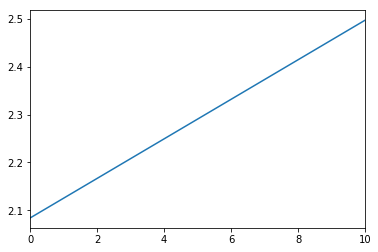

In [7]:
mPlotTop=10
plotFuncs(PFexample.solution[0].cFunc,0.,mPlotTop)

The figure illustrates one of the surprising features of the perfect foresight model: A person with zero money should be spending at a rate more than double their income ($\texttt{cFunc}(0.) \approx 2.08$). What gives?

The answer is that we have not incorporated any constraint that would prevent the agent from borrowing against the entire PDV of future earnings -- human wealth.  

How much is that?  An equivalent question is: What's the minimum value of $m_t$ where the consumption function is defined (that is, where the consumer has a positive expected _total wealth_ (the sum of human and nonuman wealth)?  Let's check:

In [8]:
humanWealth = PFexample.solution[0].hNrm
mMinimum = PFexample.solution[0].mNrmMin
print("This agent's human wealth is " + str(humanWealth) + ' times his current income level.')
print("This agent's consumption function is defined down to m_t = " + str(mMinimum))

This agent's human wealth is 50.49994992551661 times his current income level.
This agent's consumption function is defined down to m_t = -50.49994992551661


Yikes! Let's take a look at the bottom of the consumption function.  In the cell below, set the bounds of the $\texttt{plotFuncs}$ function to display down to the lowest defined value of the consumption function.

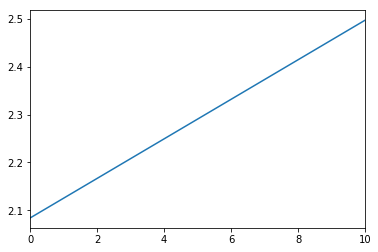

In [9]:
# YOUR FIRST HANDS-ON EXERCISE!
# Fill in the value for "mPlotBottom" to plot the consumption function from the point where it is zero.
mPlotBottom = 0. # You should replace 0. with the correct answer 
plotFuncs(PFexample.solution[0].cFunc,mPlotBottom,mPlotTop)

## Changing Agent Parameters

Suppose you wanted to change one (or more) of the parameters of the agent's problem and see what that does.  We want to compare consumption functions before and after we change parameters, so let's make a new instance of $\texttt{PerfForesightConsumerType}$ by copying $\texttt{PFexample}$.

In [10]:
NewExample = deepcopy(PFexample)

In Python, you can set an **attribute** of an object just like any other variable.  For example, we could make the new agent less patient:




The given type violates the Finite Human Wealth Condition; the Finite Human wealth factor value 1.01942  


/anaconda3/lib/python3.7/site-packages/HARK/interpolation.py:803: RuntimeWarning: divide by zero encountered in true_divide
  alpha  = (x-self.x_list[i-1])/(self.x_list[i]-self.x_list[i-1])
/anaconda3/lib/python3.7/site-packages/HARK/interpolation.py:803: RuntimeWarning: invalid value encountered in true_divide
  alpha  = (x-self.x_list[i-1])/(self.x_list[i]-self.x_list[i-1])
/anaconda3/lib/python3.7/site-packages/HARK/interpolation.py:806: RuntimeWarning: invalid value encountered in multiply
  y = (1.-alpha)*self.y_list[i-1] + alpha*self.y_list[i]


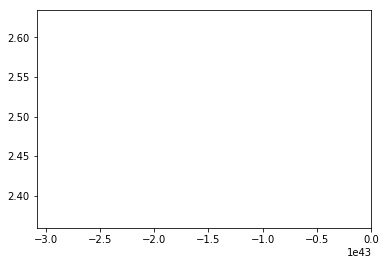

In [11]:
NewExample.DiscFac = 0.90
NewExample.PermGroFac = [1.05]
NewExample.cycles = 0
NewExample.solve()
mPlotBottom = NewExample.solution[0].mNrmMin
plotFuncs([PFexample.solution[0].cFunc,NewExample.solution[0].cFunc],mPlotBottom,mPlotTop)

(Note that you can pass a list of functions to $\texttt{plotFuncs}$ as the first argument rather than just a single function. Lists are written inside of [square brackets].)

Let's try to deal with the "problem" of massive human wealth by making another consumer who has essentially no future income.  We can almost eliminate human wealth by making the permanent income growth factor $\textit{very}$ small.

In $\texttt{PFexample}$, the agent's income grew by 1 percent per period-- his $\texttt{PermGroFac}$ took the value 1.01. What if our new agent had a growth factor of 0.01 -- his income _shrinks_ by 99 percent each period?  In the cell below, set $\texttt{NewExample}$'s discount factor back to its original value, then set its $\texttt{PermGroFac}$ attribute so that the growth factor is 0.01 each period.

Important: Recall that the model at the top of this document said that an agent's problem is characterized by a sequence of income growth factors, but we tabled that concept.  Because $\texttt{PerfForesightConsumerType}$ treats $\texttt{PermGroFac}$ as a _time-varying_ attribute, it must be specified as a **list** (with a single element in this case).

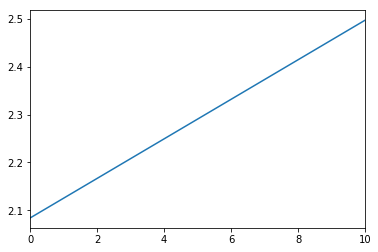

In [12]:
# Revert NewExample's discount factor and make his future income minuscule
# your lines here!

# Compare the old and new consumption functions
plotFuncs([PFexample.solution[0].cFunc,NewExample.solution[0].cFunc],0.,10.)

Now $\texttt{NewExample}$'s consumption function has the same slope (MPC) as $\texttt{PFexample}$, but it emanates from (almost) zero-- he has basically no future income to borrow against!

If you'd like, use the cell above to alter $\texttt{NewExample}$'s other attributes (relative risk aversion, etc) and see how the consumption function changes.  However, keep in mind that _no solution exists_ for some combinations of parameters.  HARK should let you know if this is the case if you try to solve such a model.


